<a href="https://colab.research.google.com/github/hayashiyus/First-steps-towards-Deep-Learning/blob/main/36_VAE.ipynb" target="_parent">
 <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#@title install packages
!pip install mplcyberpunk
!pip install watermark

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import mplcyberpunk

In [3]:
import re
import os
import copy
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <EBBC8B94-2FD8-3694-B341-8B60B237B8E9> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
np.random.seed(0)
torch.manual_seed(0)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### **1.　変分自己符号化器(VAE)**
変分自己符号化器 (Variational Autoencoder, VAE) は生成モデルの一種です．①入力画像をエンコーダーを使って潜在変数に符号化する，②次にその潜在変数をデコーダーを使って復号し再構成画像を生成する，③入力画像と再構成画像を比較して再構成誤差を計算する．このようなプロセスでVAEの訓練が行われ，一度学習が完了すれば，今度は学習済みのデコーダーに適当な潜在変数を投入することで，画像などのデータを生成できます．

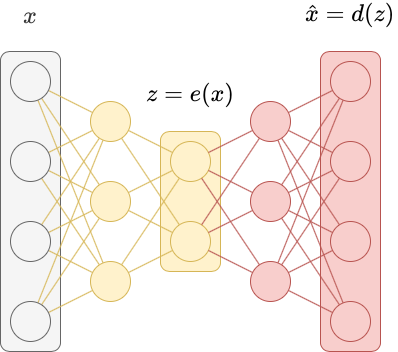

入力データ $x$ はエンコーダーによって潜在変数 $z$ に変換され，次にデコーダーを通じて再構成データ $\hat{x}$ を生成する．<br>
ここで紹介するVAEモデルは，以下の実装を参照している．<br>
https://avandekleut.github.io/vae/

##### **問1：VAEの実装**
MNISTデータセット（10クラス，28x28ピクセルの白黒画像）を使ってVAEを訓練させてください．

##### **例1**

In [7]:
latent_dims = 2

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

In [8]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc # hack to get sampling on the GPU
        self.N.scale = self.N.scale
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [9]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [10]:
def train(autoencoder, data, epochs=100):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [11]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

In [12]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [13]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.style.use("cyberpunk")
        plt.scatter(z[:, 0], z[:, 1], s=10, c=y)
        if i > num_batches:
            plt.colorbar()
            break

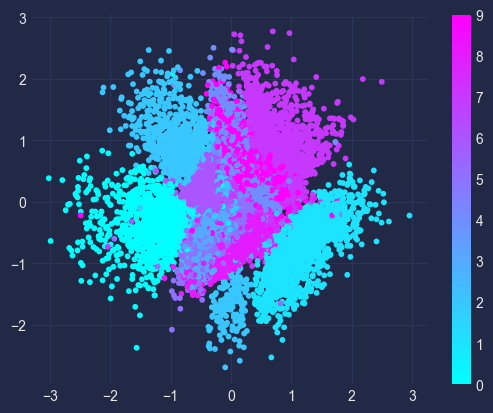

In [14]:
plot_latent(vae, data)

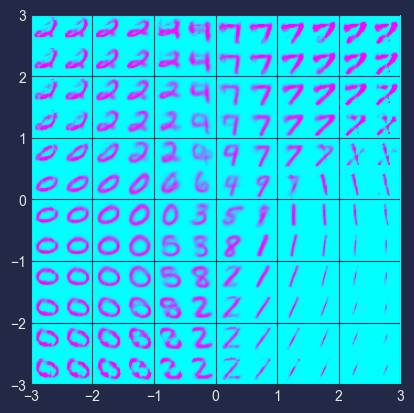

In [15]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

In [16]:
%load_ext watermark
%watermark --iversions

mplcyberpunk: 0.6.0
pandas      : 1.5.0
re          : 2.2.1
numpy       : 1.22.4
matplotlib  : 3.6.0
torch       : 1.13.1
torchvision : 0.13.1

